In [43]:
%load_ext autoreload
%autoreload 2


from pathlib import Path
from cellpose import plot, models, core, io, dynamics, omnipose
import skimage.io
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
import time, os, sys
from tifffile import imread
use_GPU = core.use_gpu()
print('>>> GPU activated? %d'%use_GPU)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
2021-11-10 18:27:41,503 [INFO] ** TORCH CUDA version installed and working. **
>>> GPU activated? 1


In [7]:
basedir = '/home/kcutler/DataDrive/omnipose_test'
mask_filter = '_masks'
img_names = io.get_image_files(basedir,mask_filter,look_one_level_down=True)
mask_names,flow_names = io.get_label_files(img_names, mask_filter)

#Name sorting is CRITICAL. This method assumes that each mask ends with _masks (png or tif)
# with identical prefixes otherwise. Cellpose cp_masks, for example, will not work and
# must be manually renamed in their folder. 
def getname(path,suffix='_masks'):
    return os.path.splitext(Path(path).name)[0].replace(suffix,'')

mask_names = sorted(mask_names,key=getname)
img_names = sorted(img_names,key=getname)
imgs = [skimage.io.imread(f) for f in img_names]
masks_gt = [omnipose.utils.format_labels(omnipose.utils.clean_boundary(skimage.io.imread(f))) for f in mask_names]

Not all flows are present. Run flow generation again.


In [8]:
basedir = '/home/kcutler/DataDrive/omnipose_all/Fig1_comparison/'

In [9]:
stardist_dir = os.path.join(basedir,'stardist')
paths = sorted(Path(stardist_dir).rglob("*masks*"),key=getname)
sd_names = [str(p) for p in paths]
masks_sd = [omnipose.utils.format_labels(omnipose.utils.clean_boundary(skimage.io.imread(f))) for f in sd_names]

In [10]:
cellpose_dir = os.path.join(basedir,'cellpose')
paths = sorted(Path(cellpose_dir).rglob("*masks*"),key=getname)
cp_names = [str(p) for p in paths]
masks_cp = [omnipose.utils.format_labels(omnipose.utils.clean_boundary(skimage.io.imread(f))) for f in cp_names]

In [11]:
superseg_dir = os.path.join(basedir,'supersegger')
paths = sorted(Path(superseg_dir).rglob("*masks*"),key=getname)
ss_names = [str(p) for p in paths]
masks_ss = [omnipose.utils.format_labels(omnipose.utils.clean_boundary(skimage.io.imread(f))) for f in ss_names]

In [12]:
mrcnn_dir = os.path.join(basedir,'mrcnn')
paths = sorted(Path(mrcnn_dir).rglob("*masks*"),key=getname)
mr_names = [str(p) for p in paths]
masks_mr = [omnipose.utils.format_labels(omnipose.utils.clean_boundary(skimage.io.imread(f))) for f in mr_names]

In [13]:
morpho_dir = os.path.join(basedir,'morphometrics/masks')
paths = sorted(Path(morpho_dir).rglob("*masks*"),key=getname)
mh_names = [str(p) for p in paths]
masks_mh = [omnipose.utils.format_labels(omnipose.utils.clean_boundary(skimage.io.imread(f))) for f in mh_names]

In [14]:
misic_dir = os.path.join(basedir,'misic')
paths = sorted(Path(misic_dir).rglob("*masks*"),key=getname)
ms_names = [str(p) for p in paths]
masks_ms = [omnipose.utils.format_labels(omnipose.utils.clean_boundary(skimage.io.imread(f))) for f in ms_names]

In [15]:
#including this in here because we want it for Fig. 5 too
omni_dir = os.path.join(basedir,'omniseg')
paths = sorted(Path(omni_dir).rglob("*masks*"),key=getname)
om_names = [str(p) for p in paths]
masks_om = [omnipose.utils.format_labels(omnipose.utils.clean_boundary(skimage.io.imread(f))) for f in om_names]
# masks_om = [skimage.io.imread(f) for f in om_names]

In [16]:
misic_train_dir = os.path.join(basedir,'misic_trained')
paths = sorted(Path(misic_train_dir).rglob("*masks*"),key=getname)
mt_names = [str(p) for p in paths]
masks_mt = [omnipose.utils.format_labels(omnipose.utils.clean_boundary(skimage.io.imread(f))) for f in mt_names]

In [17]:
masks = [masks_cp,masks_sd,masks_mr,masks_mt,masks_ms,masks_mh,masks_ss,masks_om]
# # masks = [masks_cp,masks]
print(len(masks_gt),len(masks_cp),len(masks_sd),len(masks_ss),len(masks_mh),len(masks_ms),len(masks_mt),len(masks_om))
# masks = [masks_cp,masks_om]
# masks = [masks_cp,masks]
# print(len(masks_gt),len(masks_cp),len(masks_sd),len(masks_ss),len(masks_mh),len(masks_ms),len(masks_om))

118 118 118 118 118 118 118 118


In [18]:
names = ['Cellpose','StarDist','Mask R-CNN','MiSiC','MiSiC_untrained','Morphometrics','SuperSegger','OmniSeg']
abbrv = ['CP','SD','MR','MS','MS_UT','MM','SS','OM']
# names = ['Cellpose','OmniSeg']
# abbrv = ['CP','OM']
len(masks[0]),len(masks_gt)

(118, 118)

In [19]:
from cellpose import metrics
from skimage import measure
threshold=np.linspace(0.5,1,100)
import fastremap

In [20]:
# This code ignores image boundary cells. 

ap = [[]] * len(masks) # average precision matrix per image
tp = [[]] * len(masks)
fp = [[]] * len(masks)
fn = [[]] * len(masks)
IoU = [[]] * len(masks) # Intersection over Union 
OvR = [[]] * len(masks)
pred_areas = [[]] * len(masks)

In [21]:
nimg = len(masks_gt)

In [22]:
cell_areas = [[]] * nimg
masks_gt_clean = [None]*nimg
masks_pred_clean = [[None]*nimg]*len(masks) 

In [23]:
# remapping = [[]] * nimg
for j in range(nimg):
    mgt = omnipose.utils.format_labels(omnipose.utils.clean_boundary(masks_gt[j])) ###ADD SPEEDUP FIX TO MAIN REPO
    masks_gt_clean[j] = mgt
    regions = measure.regionprops(mgt)
    areas = np.array([reg.area for reg in regions])
    cell_areas[j] =  areas

In [24]:
masks_om[15].shape,masks_gt[15].shape,mask_names[15],om_names[15],sd_names[15]

((600, 600),
 (600, 600),
 '/home/kcutler/DataDrive/omnipose_test/ecoli_mut/Az_branch_ec_22_masks.tif',
 '/home/kcutler/DataDrive/omnipose_all/Fig1_comparison/omniseg/Az_branch_ec_22_masks.png',
 '/home/kcutler/DataDrive/omnipose_all/Fig1_comparison/stardist/Az_branch_ec_22_masks.tif')

(600, 600) (600, 600) 15


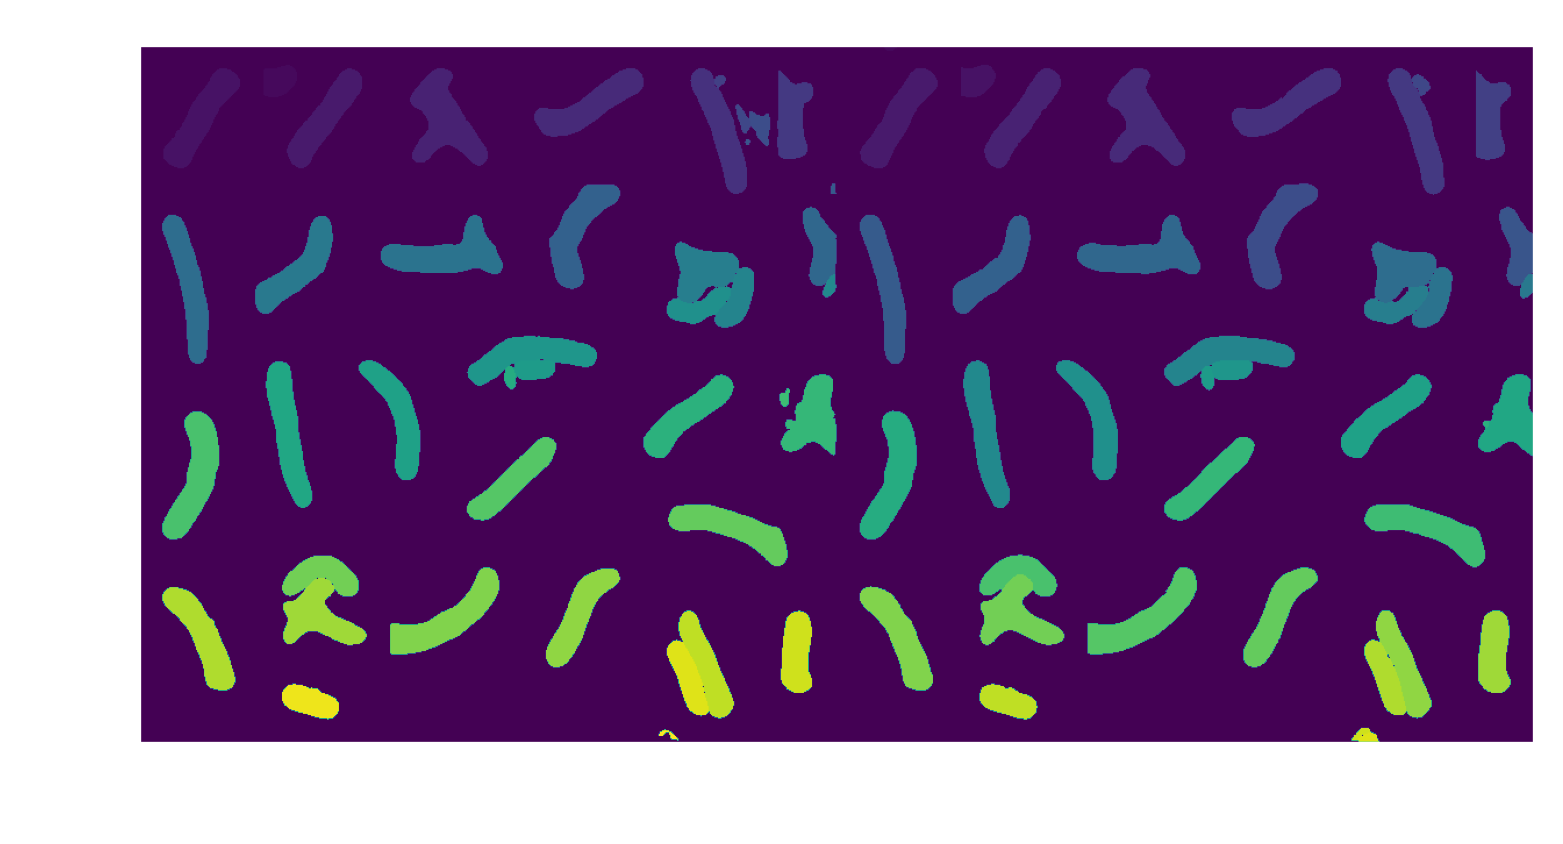

In [25]:
masks_pred = masks_om
# for j in range(nimg):
for j in [15]:
    m = masks_pred[j]
    mgt = masks_gt_clean[j]
    print(mgt.shape,m.shape,j)
    plt.imshow(np.hstack((m,mgt)))
    plt.show()
    api,tpi,fpi,fni = metrics.average_precision(mgt,m,threshold=threshold)

In [26]:
savedir = '/home/kcutler/DataDrive/omnipose_all/Fig1_comparison/'
io.check_dir(savedir)
# go over each model
for j,masks_pred in enumerate(masks):
# for j in [7]:
#     masks_pred = masks[j]

#     masks_pred = map(list,zip(*[ omnipose.utils.format_labels(omnipose.utils.clean_boundary(msk)) for msk in masks_pred]))
# just apply cleanup to the masks when reading them in 
    api,tpi,fpi,fni = metrics.average_precision(masks_gt_clean,masks_pred,threshold=threshold)
    ap[j] = ap[j]+[api]
    tp[j] = tp[j]+[tpi]
    fp[j] = fp[j]+[fpi]
    fn[j] = fn[j]+[fni]
    
    # masks_pred_clean[j] = masks_pred
    # go over every image
    print(names[j])
    for k in range(nimg):
        # get the IoU matrix; axis 0 corresponds to GT, axis 1 to pred 

        regions = measure.regionprops(masks_pred[k])
        areas = np.array([reg.area for reg in regions])
        pred_areas[j] = pred_areas[j] + [areas]
        iou = metrics._intersection_over_union(masks_gt_clean[k], masks_pred[k])

        ovp = metrics._label_overlap(masks_gt_clean[k], masks_pred[k])[1:,1:] #throw out columns corresponding to zero  
#         tp = metrics._true_positive(iou, th)

        OvR[j] = OvR[j]+[ovp / areas[np.newaxis,:]] # Overlap Ratio    

        IoU[j] = IoU[j]+[iou]
#         seg_error_percent[j] = 
    
    nm = abbrv[j]+'_'+str(j)
    np.savez(savedir+'OvR_'+nm,OvR[j])
    np.savez(savedir+'IoU_'+nm,IoU[j])
    np.savez(savedir+'cell_areas_'+nm,cell_areas[j])
    np.savez(savedir+'ap_'+nm,ap[j])

Cellpose


/home/kcutler/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


StarDist


/home/kcutler/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Mask R-CNN
MiSiC
MiSiC_untrained


/home/kcutler/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


Morphometrics
SuperSegger
OmniSeg


In [27]:
# metrics.average_precision(masks_gt_clean,masks_pred,threshold=threshold)
# len(masks_gt_clean)
# mp = masks[6][4]
# m = masks_gt[4]
# # plt.imshow(np.hstack((p,m,p==m)))
# iou = metrics._intersection_over_union(m, mp)
# ovp = metrics._label_overlap(m, mp)[1:,1:]
# regions = measure.regionprops(mp)
# areas = np.array([reg.area for reg in regions])
# ovp / areas[np.newaxis,:]
ap[1][0]

array([[0.9649924 , 0.9620061 , 0.9620061 , ..., 0.        , 0.        ,
        0.        ],
       [0.96245736, 0.96245736, 0.96245736, ..., 0.        , 0.        ,
        0.        ],
       [0.9793388 , 0.9793388 , 0.9793388 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.8023256 , 0.7919075 , 0.77820265, ..., 0.        , 0.        ,
        0.        ],
       [0.8820225 , 0.8820225 , 0.8820225 , ..., 0.        , 0.        ,
        0.        ],
       [0.8047138 , 0.7986577 , 0.7926421 , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)

In [28]:
areas

array([207, 186, 323, 373, 234, 201, 184, 217, 206, 220, 200, 200, 174,
       209, 154, 137, 169, 325, 165, 155, 302, 225, 317, 196, 218, 180,
       177, 291, 308, 135, 173, 264, 225, 397, 247, 246, 208, 205, 268,
       220, 234, 242, 216, 191, 401, 222, 217, 338, 163, 172, 174, 203,
       257, 193, 144, 206, 359, 203, 142, 181, 167, 184, 148, 227, 349,
       191, 196, 219, 203, 147, 259, 210, 224, 224, 207, 171, 217, 189,
       171, 173, 221, 179, 179, 192, 207, 174, 235, 211, 197, 219, 246,
       189, 360, 246, 151, 208, 178, 191, 183,  57, 208, 160, 120, 201,
        86, 230, 181, 190, 224, 176, 160, 198, 287, 300, 237, 237, 140,
       493, 306, 229, 182, 187, 175, 212, 204, 251, 175, 300, 129, 223,
       140, 214, 216, 203, 200, 268, 215, 185, 140, 168, 230, 145, 164,
       281, 296, 125, 191, 304, 253, 207, 300, 243, 262, 300, 281,  51,
        41,  15,  44,  30, 224, 180, 208, 132, 173, 202, 171, 156,  39,
        24,  18, 156, 188, 210, 205, 192, 194, 177, 164, 166, 24

In [30]:
# args = np.argsort(x)
# sort_names = [names[i] for i in args]
# print(args,sort_names)
# args = args[args!=0].tolist()
# args=[0]+args
# args

In [31]:
savedir = '/home/kcutler/DataDrive/omnipose_all/Fig1_comparison/test'
io.check_dir(savedir)

In [32]:
# save output
np.savez(savedir+'OvR',OvR)
np.savez(savedir+'IoU',IoU)
np.savez(savedir+'cell_areas',cell_areas)
np.savez(savedir+'ap',ap)

In [33]:
# load back in 
OvR = np.load(savedir+'OvR'+'.npz',allow_pickle=True)['arr_0']
IoU = np.load(savedir+'IoU'+'.npz',allow_pickle=True)['arr_0']
cell_areas = np.load(savedir+'cell_areas'+'.npz',allow_pickle=True)['arr_0']
# remapping = np.load(savedir+'remapping'+'.npz',allow_pickle=True)['arr_0']
ap = np.load(savedir+'ap'+'.npz',allow_pickle=True)['arr_0']

In [34]:
len(ap)

8

In [63]:
#split dataset into different categories 

cats = ['regular morphologies','mutants, antibiotics',' elongated wildtype']
subsets= [['5I_crop','PAO1_Staph','PSVB','Serratia_Ecoli','wiggins','vibrio','bthai'],
          ['Hpylori','dnaA','ftsN','murA','cex','A22','Az'],['caulo','streptomyces']]
exclude = 'fggdffdgdf'#'caulo_14'
K = len(cats)
indices = [np.array([i for i,s in enumerate(mask_names) if any((name in s) and (exclude not in s) for name in subsets[k])]).astype(int) for k in range(K)]

counts = np.zeros((3,1))
for j,inds in enumerate(indices):
    # print(j)
    for i in inds:
        # print(len(np.unique(masks_gt_clean[i]))-1)
        counts[j] +=len(np.unique(masks_gt_clean[i]))-1
counts

array([[12869.],
       [ 6138.],
       [   46.]])

In [64]:
from scipy.optimize import linear_sum_assignment

per_cell = 1
J = len(IoU)
K = len(cats)
# y = [[]*K]*J #BADDDDDDDDDD! Need to check my other results to make sure it was done correctly, https://stackoverflow.com/questions/54673821/python-how-to-initialize-a-nested-list-with-empty-values-which-i-can-append-to 
y = [ [ [] for i in range(K) ] for i in range(J) ]
for j in range(J):
    for k in range(K):
        matched_iou = []
        mean_matched_iou = []
        for ind in indices[k]:
            iou = IoU[j][ind][1:,1:]
            th = 0
            n_min = min(iou.shape[0], iou.shape[1])
            costs = -(iou >= th).astype(float) - iou / (2*n_min)
            true_ind, pred_ind = linear_sum_assignment(costs)
            miou = iou[true_ind, pred_ind]
            matched_iou.append(miou)
            mean_matched_iou.append(np.sum(miou)/max(iou.shape[0], iou.shape[1]))
            
        y[j][k] = [m for sublist in matched_iou for m in sublist] if per_cell else mean_matched_iou


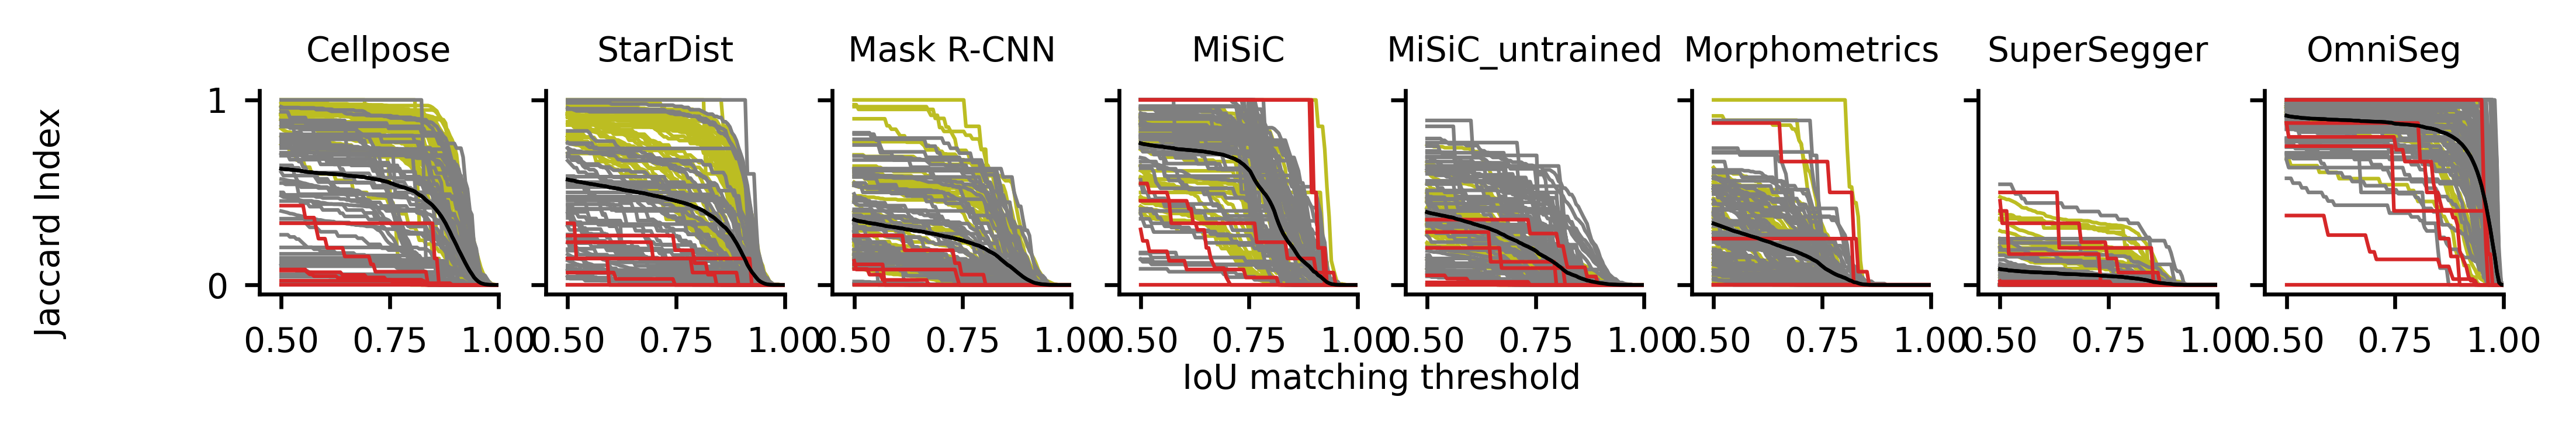

In [65]:
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

from cellpose.omnipose.utils import sinebow
J = len(IoU)
linestyle='-'
# master_color_scheme = ['r','b','g']

%matplotlib inline
darkmode = False
if darkmode:
    plt.style.use('dark_background')
    axcol = 'w'
    colors = sinebow(J+1)
    colors = [colors[j+1] for j in range(n)]
    background_color = 'k'
else:
    mpl.rcParams.update(mpl.rcParamsDefault)
    axcol = 'k'
    cmap = mpl.cm.get_cmap('viridis')
#     colors = cmap(np.linspace(0,.9,len(names)))
#     colors = master_color_scheme
    background_color = np.array([1,1,1,1])
    
mpl.rcParams['figure.dpi'] = 300

x = threshold
golden = (1 + 5 ** 0.5) / 2
sz = 8
labelsize = 7
# fig = plt.figure(figsize=(sz, sz/golden)) 
# fig = plt.figure(figsize=(sz, sz/2)) 
# ax = plt.axes()
fig, axs = plt.subplots(1,len(names),figsize=(sz,sz/J),sharex=True, sharey=True)

colors = ['tab:olive','tab:gray','tab:red']
# plt.tight_layout()
# plt.minorticks_on()
plt.xticks(np.arange(min(x), max(x)+1, .25))
# plt.xlim([0.45,1.05])
# plt.ylim([0,1])
# plt.yticks(np.arange(0, 1.1, .25))

# colors = ['g','r','b','y','c','m']
# pretty_names = ['Original Cellpose','','','Mixed Method','','','','New Method']
cell_count = np.array([len(np.unique(ca)) for ca in cell_areas])
# for j in range(n):
# sort_colors = [colors[j] for j in args]
# colors = ['r',[.75,.75,.75],[0,0,0],[.5,.5,.5],[1,0,0]]

fill = 0
per_image = 1
density = 0

l = np.array([len(indices[k]) for k in range(K)])
# alpha = 1.5/(1+l/np.min(l))
alpha = [1,1,1]

from scipy.stats import gaussian_kde

for j in range(J):
    
    mean = np.mean(ap[j][0],axis=0).T
    ax = axs[j]
    if fill:
        err = np.std(ap[j][0],axis=0).T
        ax.plot(x,mean,label=names[j],color=colors[j],linestyle=linestyle)
        ax.fill_between(x,mean-err,mean+err,facecolor=colors[j],alpha=0.5)
    if per_image:
#         ax.plot(x,ap[j][0].T,label=names[j],color=colors[j],linestyle=linestyle,alpha=.05)
#         ax.plot(x,mean,label=names[j],color='k',linestyle=linestyle)
        for k in range(K):
#             if k<K-1:
#                 alpha = .25
#             else:
#                 alpha = .5
            arr =ap[j][0][indices[k]].T
            ax.plot(x,arr,label=names[j],color=colors[k],linestyle=linestyle,alpha=alpha[k],lw=.75)
            ax.plot(x,mean,label=names[j],color='k',linestyle=linestyle,lw=.75)
    if density:
        y = np.array(ap[j]).T.flatten()
        X = np.repeat(x,len(ap[j][0]))
        xy = np.vstack([X,y])
        z = gaussian_kde(xy)(xy)
        idx = z.argsort()
        X, y, z = X[idx], y[idx], z[idx]
        ax.scatter(X, y, c=np.log(z), s=1)
    # ax.set_facecolor('w')
    # ax.legend(prop={'size': labelsize}, loc='upper left', frameon=False,bbox_to_anchor=(1.05, 1))
#     ax.legend(prop={'size': 5}, loc='best', frameon=False)
    ax.set_title(names[j],fontsize=labelsize)
    ax.tick_params(axis='both', which='major', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=True,left=True)
    ax.tick_params(axis='both', which='minor', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=True,left=True)
#     ax.tick_params(axis='x', which='both', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=0,left=0,labelbottom=0)

#     if j==J-1:
#         ax.set_xlabel('IoU threshold', fontsize = labelsize)
#         ax.tick_params(axis='x', which='both', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=True,left=True,labelbottom=1)
#         ax.tick_params(axis='x', which='minor', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=True,left=True,labelbottom=1)

#     ax.set_ylim((0,1))
    ax.set_xlim((.5-.05,1))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.patch.set_alpha(0.0)

plt.subplots_adjust(bottom=.3,left=.1)
fig.patch.set_facecolor(background_color)
fig.supylabel('Jaccard Index', fontsize = labelsize)
fig.supxlabel('IoU matching threshold', fontsize = labelsize)
# swap last two 
# pos = axs[-1].get_position()
# axs[-1].set_position(axs[-2].get_position())
# axs[-2].set_position(pos)
# 
# plt.set(xlabel='IoU threshold', ylabel='Average Precision',fontsize=labelsize)
# plt.tight_layout()
# plt.yscale('log')



plt.show()

tight_bbox_raw = ax.get_tightbbox(fig.canvas.get_renderer())
a = 50
tight_bbox_raw._points+=[[-a,-a],[a,a]]
tight_bbox = mpl.transforms.TransformedBbox(tight_bbox_raw, mpl.transforms.Affine2D().scale(1./fig.dpi))

# fig.savefig('/home/kcutler/DataDrive/omnipose_paper/Fig_1_comparison.eps',bbox_inches=tight_bbox)
# fig.savefig('/home/kcutler/DataDrive/omnipose_paper/Fig_1_comparison',bbox_inches=tight_bbox)
# fig.savefig('/home/kcutler/DataDrive/omnipose_paper/AP_vs_IoU_row.eps',bbox_inches="tight",pad_inches = 0.05)
# fig.savefig('/home/kcutler/DataDrive/omnipose_paper/AP_vs_IoU_row.png',bbox_inches="tight",pad_inches = 0.05)


#SOMETHIGN FUNKY WITH THAT RED LINE FOR OMNI

In [66]:
ap[j].shape

(1, 118, 100)

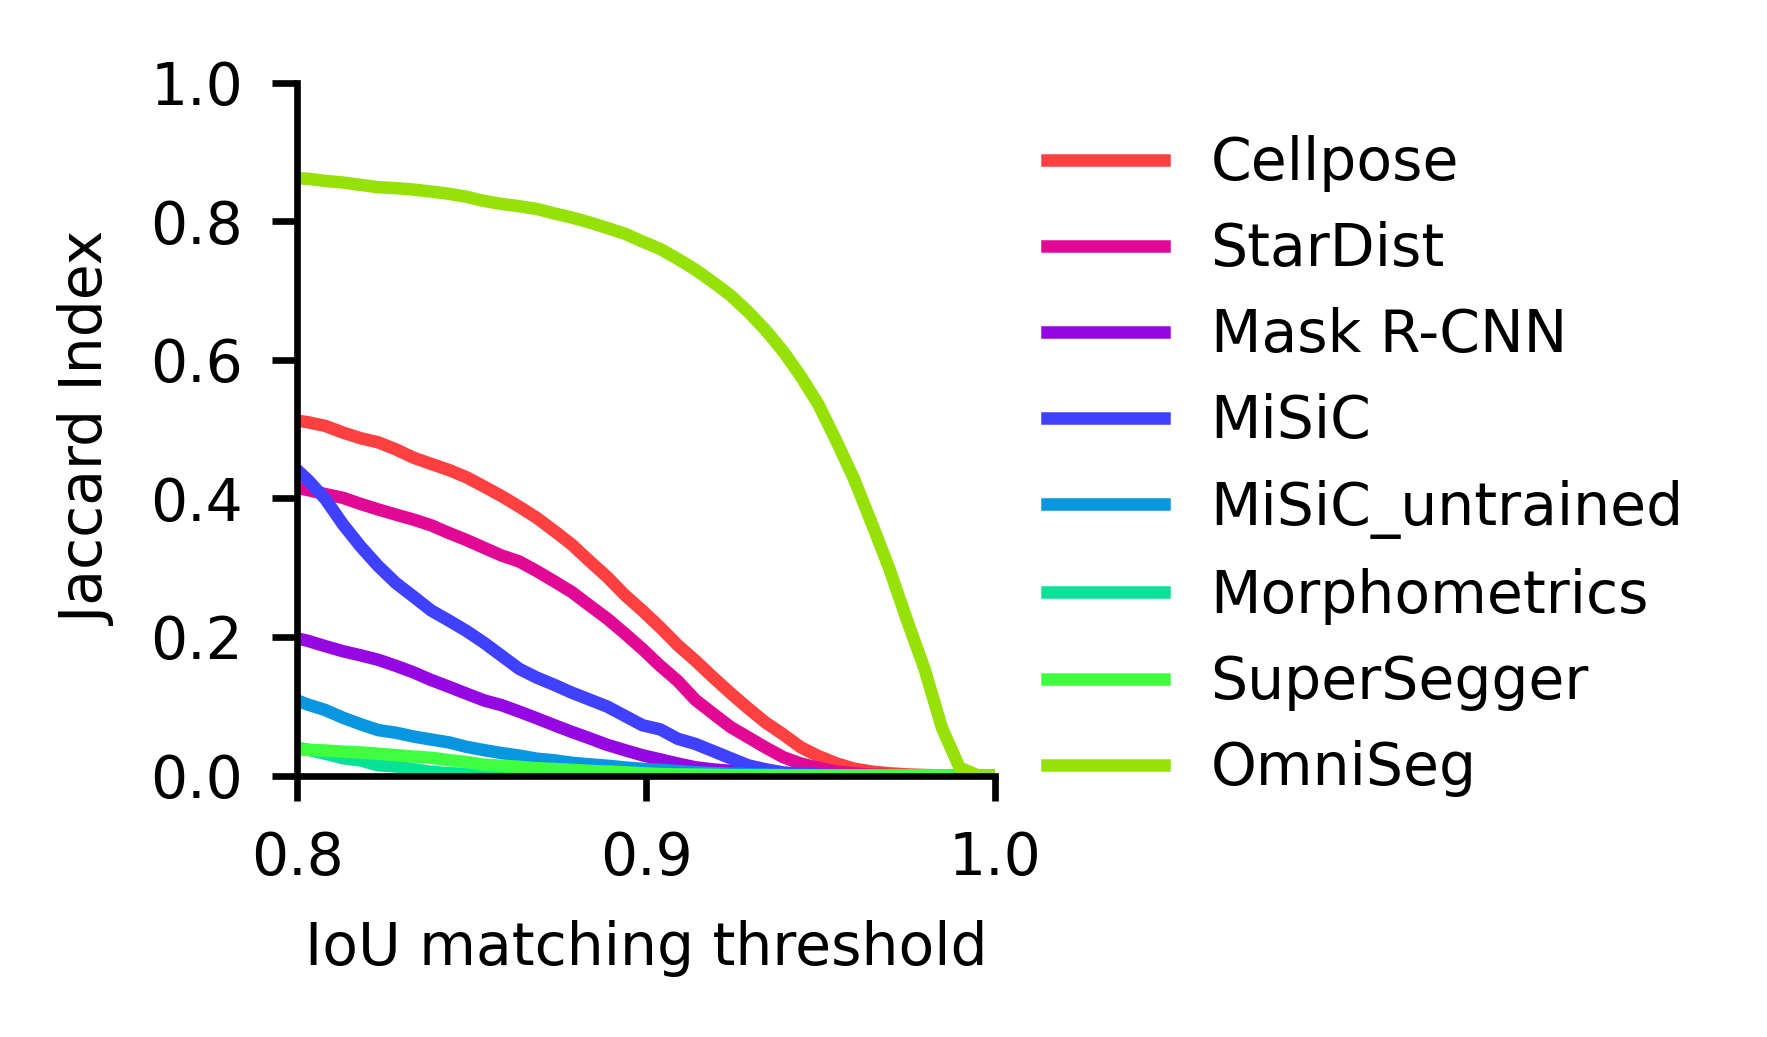

In [76]:
# fig = plt.figure(figsize=(sz, sz/golden)) 
sz = 1.5
fig = plt.figure(figsize=(sz, sz)) 
ax = plt.axes()


plt.xticks(np.arange(min(x), max(x)+1, .25))
# plt.xlim([0.45,1.05])
# plt.ylim([0,1])
# plt.yticks(np.arange(0, 1.1, .25))

# colors = ['g','r','b','y','c','m']
# pretty_names = ['Original Cellpose','','','Mixed Method','','','','New Method']
cell_count = np.array([len(np.unique(ca)) for ca in cell_areas])
# for j in range(n):
# sort_colors = [colors[j] for j in args]
# colors = ['r',[.75,.75,.75],[0,0,0],[.5,.5,.5],[1,0,0]]
colors = sinebow(J+1)
colors = [colors[j+1] for j in range(J)]

fill = 0
per_image = 1
density = 0

l = np.array([len(indices[k]) for k in range(K)])
# alpha = 1.5/(1+l/np.min(l))
alpha = [1,1,1]

from scipy.stats import gaussian_kde
# colors = ['k',[.5,.5,.5],[.8,.8,.8],'y','r']


for j in range(J):
    names[j]
    colors[j]
    ax.plot(x,np.mean(ap[j][0],axis=0).T,label=names[j],color=colors[j])
    # ax.legend(prop={'size': labelsize}, loc='upper left', frameon=False,bbox_to_anchor=(1.05, 1))
#     ax.legend(prop={'size': 5}, loc='best', frameon=False)
    
    ax.tick_params(axis='both', which='major', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=True,left=True)
    ax.tick_params(axis='both', which='minor', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=True,left=True)
#     ax.tick_params(axis='x', which='both', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=0,left=0,labelbottom=0)

#     if j==J-1:
#         ax.set_xlabel('IoU threshold', fontsize = labelsize)
#         ax.tick_params(axis='x', which='both', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=True,left=True,labelbottom=1)
#         ax.tick_params(axis='x', which='minor', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=True,left=True,labelbottom=1)

#     ax.set_ylim((0,1))
    ax.set_xlim((.8,1))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.patch.set_alpha(0.0)

# ax.vlines(.8,0,1,colors=[.5]*4,linestyles='dashed',linewidth=1)

fig.patch.set_facecolor(background_color)
plt.ylabel('Jaccard Index', fontsize = labelsize)
plt.xlabel('IoU matching threshold', fontsize = labelsize)
# swap last two 
# pos = axs[-1].get_position()
# axs[-1].set_position(axs[-2].get_position())
# axs[-2].set_position(pos)
# 
# plt.set(xlabel='IoU threshold', ylabel='Average Precision',fontsize=labelsize)
# plt.tight_layout()
# plt.yscale('log')
ax.legend(prop={'size': labelsize}, loc='upper left', frameon=False,bbox_to_anchor=(1.0, 1))
# ax.set_yscale('log')
# ax.set_ylim(1e-3,1)
ax.set_ylim(0,1)
ax.set_xticks([.8,.9,1])
# plt.subplots_adjust(bottom=.3,left=0,right=1)

plt.show()

tight_bbox_raw = ax.get_tightbbox(fig.canvas.get_renderer())
a = 50
tight_bbox_raw._points+=[[-a,-a],[a,a]]
tight_bbox = mpl.transforms.TransformedBbox(tight_bbox_raw, mpl.transforms.Affine2D().scale(1./fig.dpi))

# fig.savefig('/home/kcutler/DataDrive/omnipose_paper/Fig_1_comparison.eps',bbox_inches=tight_bbox)
# fig.savefig('/home/kcutler/DataDrive/omnipose_paper/Fig_1_comparison',bbox_inches=tight_bbox)
# fig.savefig('/home/kcutler/DataDrive/omnipose_paper/AP_vs_IoU_row.eps',bbox_inches="tight",pad_inches = 0.05)
# fig.savefig('/home/kcutler/DataDrive/omnipose_paper/AP_vs_IoU_row.png',bbox_inches="tight",pad_inches = 0.05)

Cellpose Percent above 0.8 [array([90.34112985]), array([68.18181818]), array([19.56521739])] 0.8303154358893613
StarDist Percent above 0.8 [array([76.40842334]), array([39.26360378]), array([8.69565217])] 0.6427859129795833
Mask R-CNN Percent above 0.8 [array([19.40321703]), array([21.63571196]), array([2.17391304])] 0.20080827166325513
MiSiC Percent above 0.8 [array([35.50392416]), array([63.48973607]), array([21.73913043])] 0.4448643258279536
MiSiC_untrained Percent above 0.8 [array([4.87217344]), array([18.70316064]), array([13.04347826])] 0.09347609300372645
Morphometrics Percent above 0.8 [array([1.65514026]), array([5.16454871]), array([13.04347826])] 0.02813205269511363
SuperSegger Percent above 0.8 [array([13.45092859]), array([5.01792115]), array([4.34782609])] 0.1071222379677741
OmniSeg Percent above 0.8 [array([94.57611314]), array([95.14499837]), array([73.91304348])] 0.947094945677846


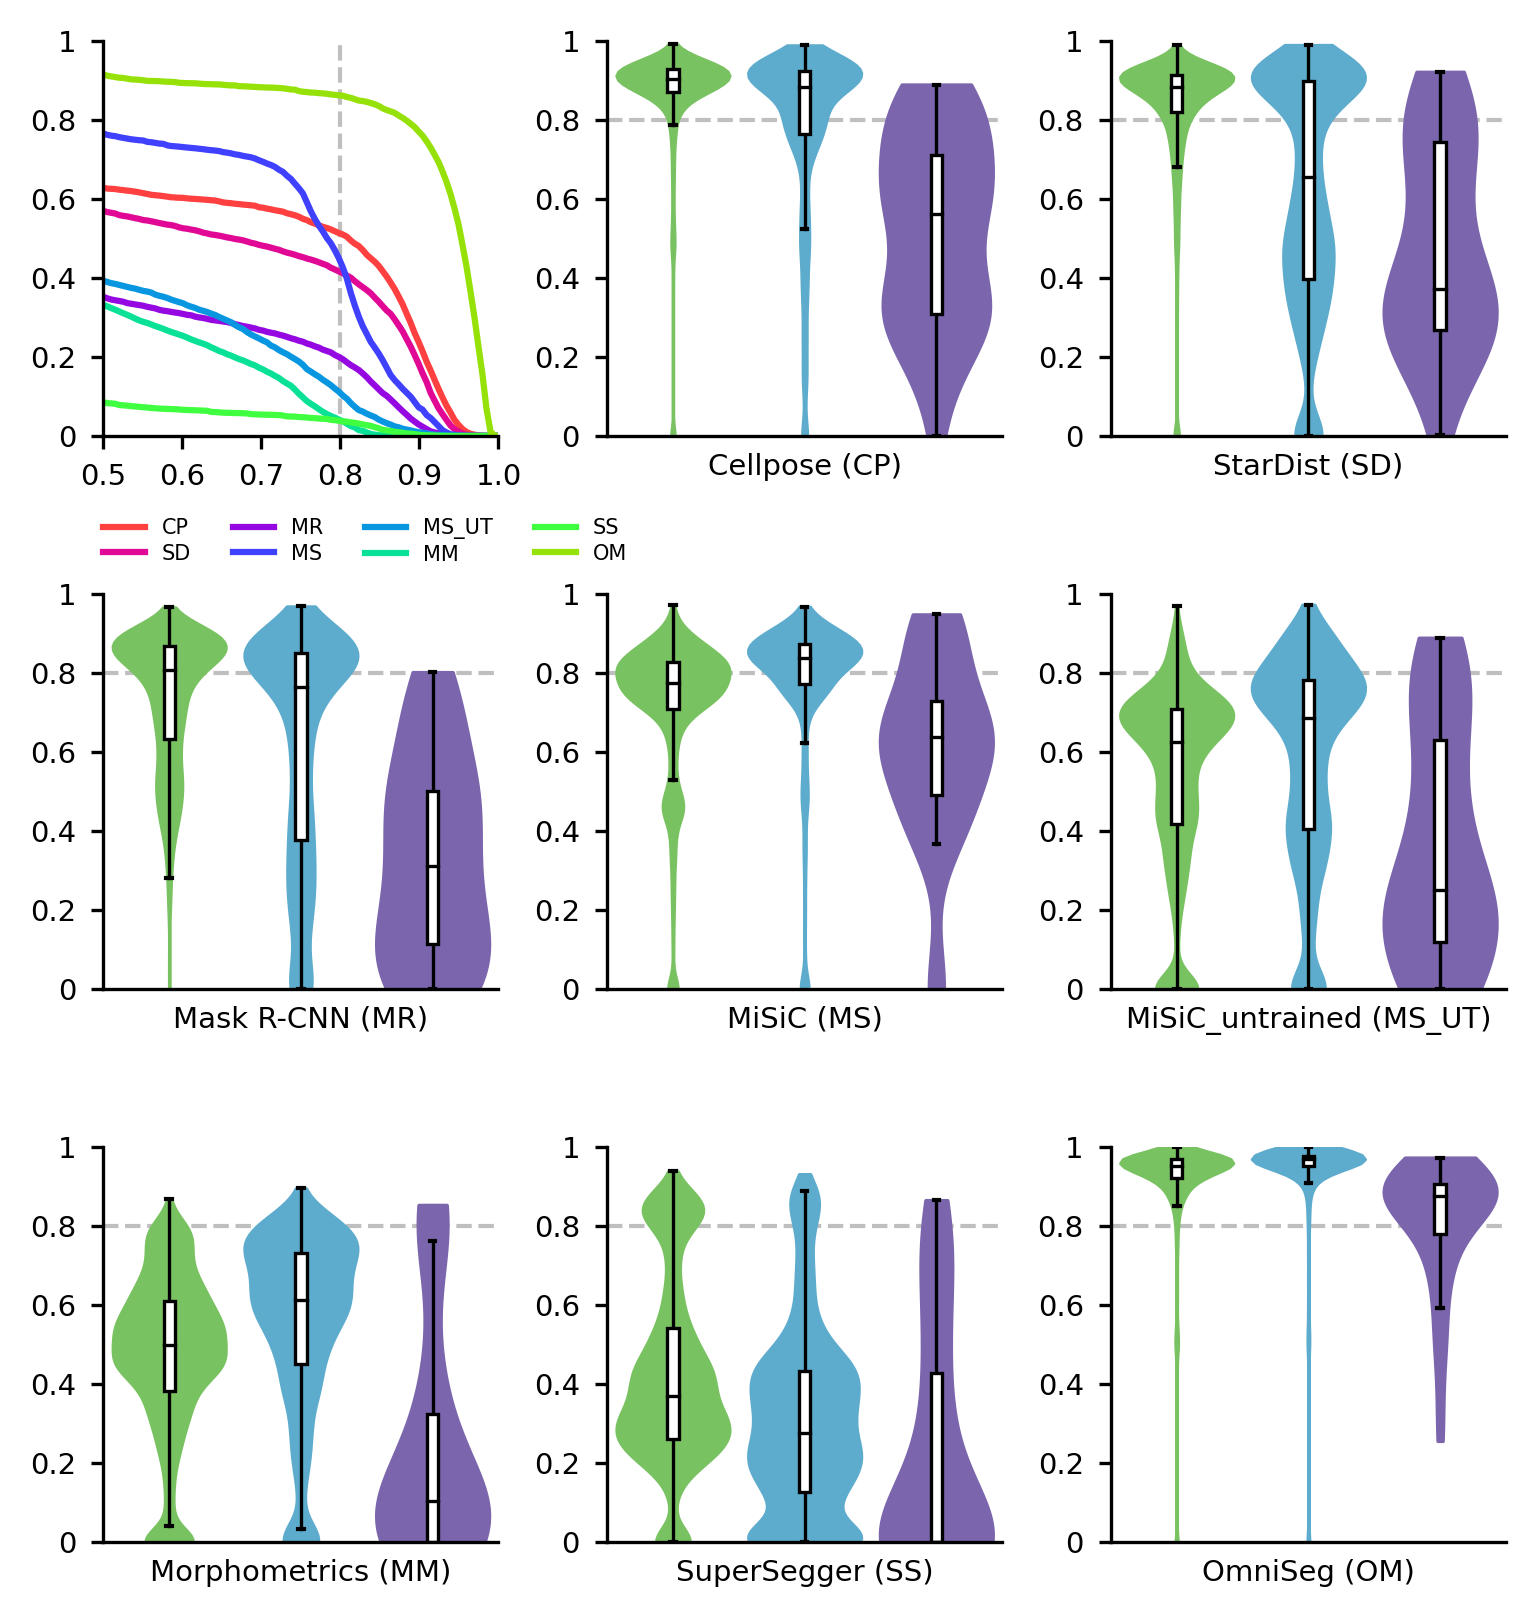

In [49]:
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams["text.usetex"] = True
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams.update({
    "text.usetex": False,########################
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# matplotlib_inline.backend_inline.set_matplotlib_formats('retina', 'png')
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams["ps.usedistiller"] = 'xpdf'
mpl.rc('text.latex', preamble=r'\usepackage{cmbright}')

# plt.hist(IoU[1][indices[1]].transpose())
# plt.show()
import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from matplotlib.lines import Line2D
import seaborn as sns
np.random.seed(123)
w0 = 0.7
split=1
box = False
scatter = 0
violin = 1

J = len(IoU)

# sz = 6.5
sz = 6.5
fig, axs = plt.subplots(3,3,figsize=(sz,sz))
plt.subplots_adjust(wspace=.4, hspace = .4)
axs = axs.flatten()
# plot AP vs IoU
c = sinebow(J+1)
APcolors = [c[j+1] for j in range(J)]

# cmap = mpl.cm.get_cmap('Accent')
# APcolors = cmap(np.linspace(0,1,len(names)))

# APcolors = np.array([[1,0,0],[1,.5,.5],[1,.75,.75],[0,0,0],[.75,.75,.75]])
# APcolors = np.array([[.25,1,.25],[.75,1,.25],[.85,.85,.25],[0,0,0],[.75,.75,.75]])

# cmap1 = np.fliplr(sns.color_palette("YlGn_r", 6))[:3]
# APcolors = list(cmap1[:])
# APcolors.append('gray')
# APcolors.append('b')

ax = axs[0]
for j in range(J):
    names[j]

    x = threshold
    ax.plot(x,np.mean(ap[j][0],axis=0).T,label=abbrv[j],color=APcolors[j])

ax.vlines(.8,0,1,colors=[.5]*4,linestyles='dashed',linewidth=1)
legend = ax.legend(prop={'size': 5}, loc='lower left', ncol=int(J/2),frameon=False, bbox_to_anchor=(0, -.325),borderpad=0,
                   labelspacing=.25,borderaxespad=0)
# ax.legend(prop={'size': 5}, frameon=True)
# for t in legend.get_texts():
#     t.set_ha('right') # ha is alias for horizontalalignment
#     t.set_position((.1,0))


ax.tick_params(axis='both', which='major', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=True,left=True)
ax.tick_params(axis='both', which='minor', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=True,left=True)
#     ax.tick_params(axis='x', which='both', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=0,left=0,labelbottom=0)

#     if j==J-1:
#         ax.set_xlabel('IoU threshold', fontsize = labelsize)
#         ax.tick_params(axis='x', which='both', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=True,left=True,labelbottom=1)
#         ax.tick_params(axis='x', which='minor', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=True,left=True,labelbottom=1)

ax.set_ylim((0,1))
ax.set_xlim((.5,1))
ax.set_xticks(np.linspace(.5,1,6))

ax.set_yticks(np.linspace(0,1,6))
ax.set_yticklabels([0,.2,.4,.6,.8,1])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.patch.set_alpha(0.0)
#     ax.set(adjustable='box', aspect=1/2)
ax.set_box_aspect(1)

lw = .8

# violin plots
c = omnipose.utils.sinebow(K)
colors = np.array(list(c.values()))[1:]
colors = colors.copy()
colors[:,-1] = 1
colors = ['tab:green','tab:gray','tab:red']


cmap = sns.diverging_palette(0, 100, n=3)
cmap = sns.color_palette("husl", 8)

colors = cmap[:]

colors = ['#79C261','#5EACCD','#7B66AD']

for j in range(J):
    ax = axs[j+1]
    
    if split:
        w = w0 / 3
        x = [j-w,j,j+w]
    else:
        x = [j,j,j]
        w = w0
    height = [np.mean(yi) for yi in y[j]]
    percents = [np.sum(np.array(yi)>0.8)/counts[k]*100 for k,yi in enumerate(y[j])]
    overall_percent = np.sum([np.sum(np.array(yi)>0.8) for yi in y[j]]) / np.sum(counts)
    print(names[j], 'Percent above 0.8',percents,overall_percent)#,height,len(y[j]))
    parts = ax.violinplot(y[j],positions=x,showextrema=0,widths=w0/3.5)#showmeans=1,quantiles = [[.25,.75]]*len(x),
    boxes = ax.boxplot(y[j],positions=x,showfliers=False,widths=w0/35,patch_artist=True,
                       boxprops=dict(facecolor='w', color='k',linewidth=lw),whiskerprops=dict(color='k',linewidth=lw),
                       medianprops=dict(color='k',linewidth=lw)) 
    for i,pc in enumerate(parts['bodies']):
        pc.set_facecolor(colors[i])
        pc.set_alpha(1)
        pc.set_edgecolor(colors[i])
        pc.set_linewidth(lw)
    # parts['cmeans'].set_color('k')
    # parts['cquantiles'].set_color('r')
    # parts['cmeans'].set_linewidth(1.5)
    # parts['cquantiles'].set_linewidth(1)
    # for i, box in enumerate(boxes):
    #     box.set_facecolor('w')
    # plt.setp(boxes["boxes"], facecolor='w')
    
    ax.set_ylim((0,1))
    ax.set_xlim((j-w0/2,j+w0/2))
    ax.set_xticks([])
    ax.set_yticks(np.linspace(0,1,6))
    ax.set_yticklabels([0,.2,.4,.6,.8,1])
    ax.tick_params(axis='both', which='major', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=True,left=True)
    ax.tick_params(axis='both', which='minor', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=True,left=True)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.patch.set_alpha(0.0)
    ax.set_xlabel(names[j]+' ('+abbrv[j]+')', fontsize = labelsize)
    bbx = ax.get_window_extent()
    # print(ax.get_aspect(),bbx.height/bbx.width)
#     ax.set(adjustable='box', aspect=bbx.width/bbx.height)
    ax.set_box_aspect(1)
    ax.xaxis.get_major_formatter()._usetex = False
    ax.yaxis.get_major_formatter()._usetex = False
    xlim = ax.get_xlim()
    ax.hlines(.8,xlim[0],xlim[-1],colors=[.5]*4,linestyles='dashed',linewidth=1,zorder=0)

#             pc.set_alpha(1)
#         ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)

# ax.legend(prop={'size': labelsize}, loc='best', frameon=False)
# ax.legend(prop={'size': labelsize}, loc='upper left', frameon=False,bbox_to_anchor=(1.0, 1))

# ax.set_xticks(range(J))
# ax.set_xticklabels(names)

# ax.tick_params(axis='both', which='major', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=True,left=True)
# ax.tick_params(axis='both', which='minor', labelsize=labelsize,length=3, direction="out",colors=axcol,bottom=True,left=True)
# # ax.set_ylabel('Mean Matched IoU', fontsize = labelsize)
# # ax.set_xlabel('Algorithm', fontsize = labelsize)

ax.patch.set_alpha(0.0)
plt.subplots_adjust(wspace=0)

plt.show()
# fig.savefig('/home/kcutler/DataDrive/omnipose_paper/fig1_grid.eps',bbox_inches="tight",pad_inches = 0.05)
# fig.savefig('/home/kcutler/DataDrive/omnipose_paper/fig1_grid.png',bbox_inches="tight",pad_inches = 0.05)
fig.savefig('/home/kcutler/DataDrive/omnipose_paper/fig1_grid.pdf',bbox_inches="tight",pad_inches = 0.05)

In [50]:
fig1_names = ['Az_branch_ec_0_','Az_branch_ec_14_','Az_branch_ec_10_','PSVB_ensemble_c_0_', 'PSVB_ensemble_c_1_','streptomyces_XY15_1_']
# fig1_names = ['streptomyces_XY15_1_','Az_branch_ec_0_', 'PSVB_ensemble_c_1_']

N = len(fig1_names)
fig1_indices = np.array([i for i,s in enumerate(mask_names) if any(name in s for name in fig1_names)]).astype(int)
fig1_indices

array([ 7,  8, 10, 36, 37, 98])

['Cellpose', 'StarDist', 'Mask R-CNN', 'MiSiC', 'MiSiC_untrained', 'Morphometrics', 'SuperSegger', 'OmniSeg']
/home/kcutler/DataDrive/omnipose_test/caulo/caulo_14_masks.tif
shape (66, 58)


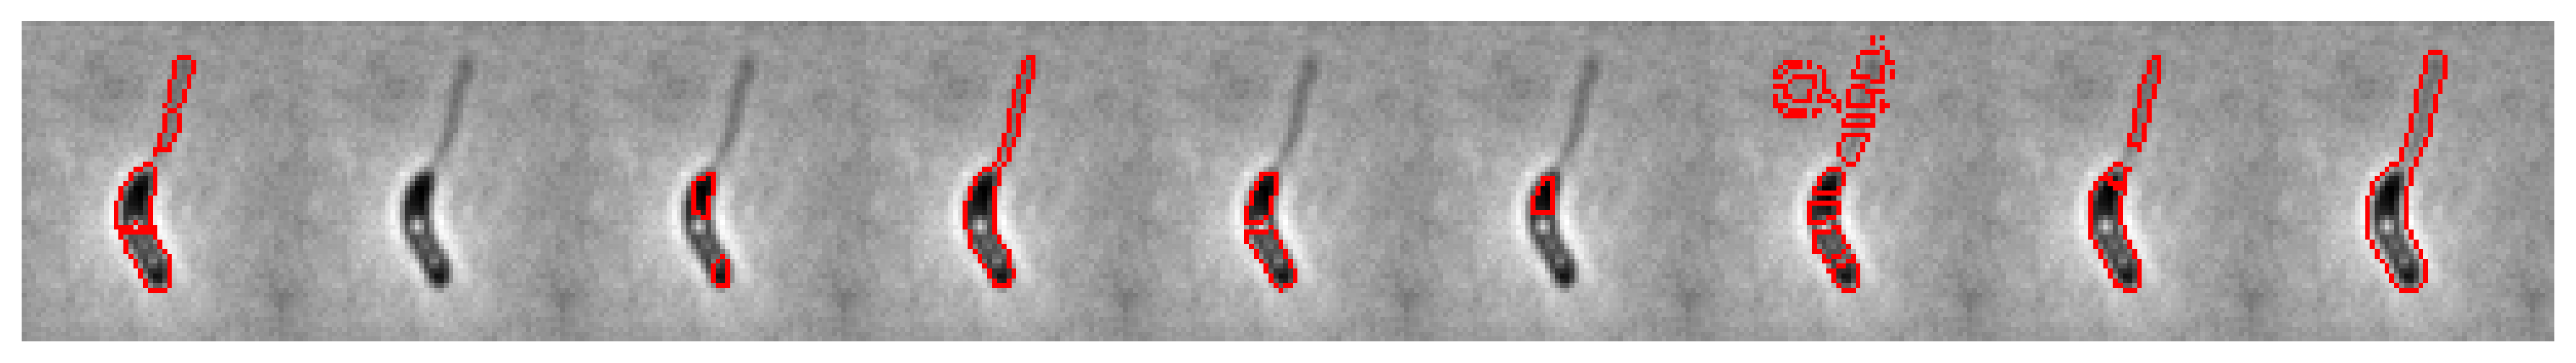

/home/kcutler/DataDrive/omnipose_test/caulo/caulo_15_masks.tif
shape (281, 310)


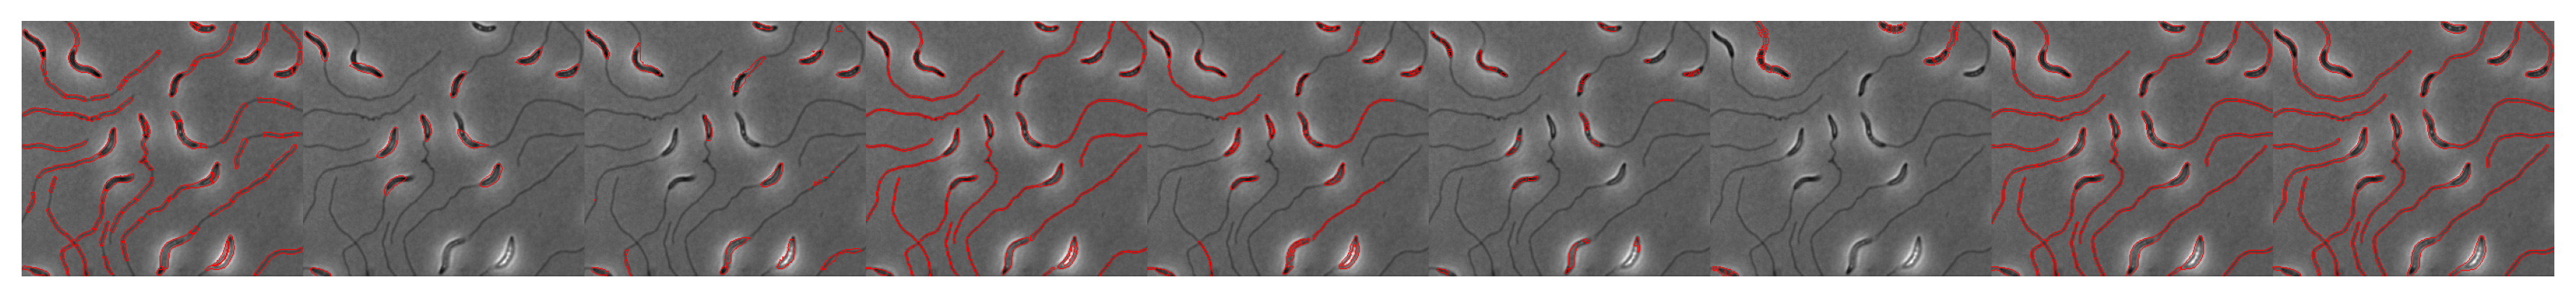

/home/kcutler/DataDrive/omnipose_test/caulo/caulo_6_masks.tif
shape (93, 197)


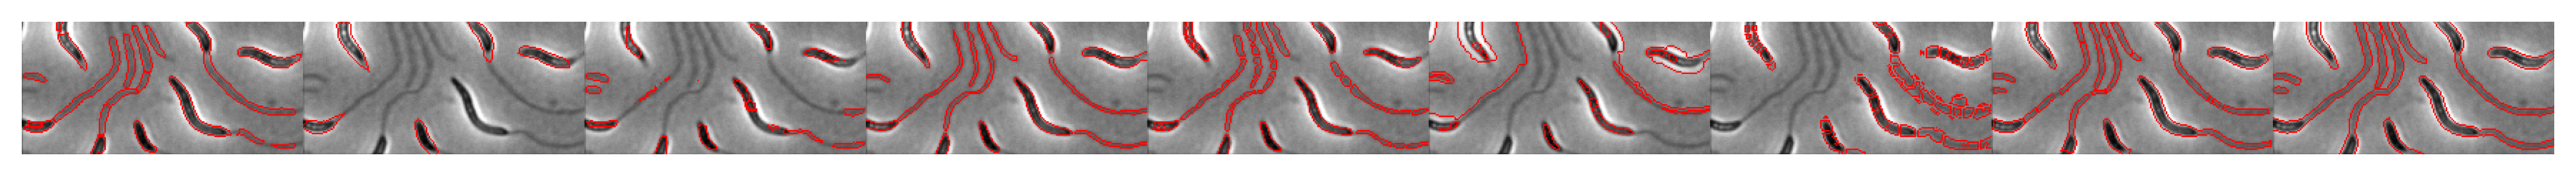

/home/kcutler/DataDrive/omnipose_test/streptomyces/streptomyces_XY15_1_masks.tif
shape (401, 190)


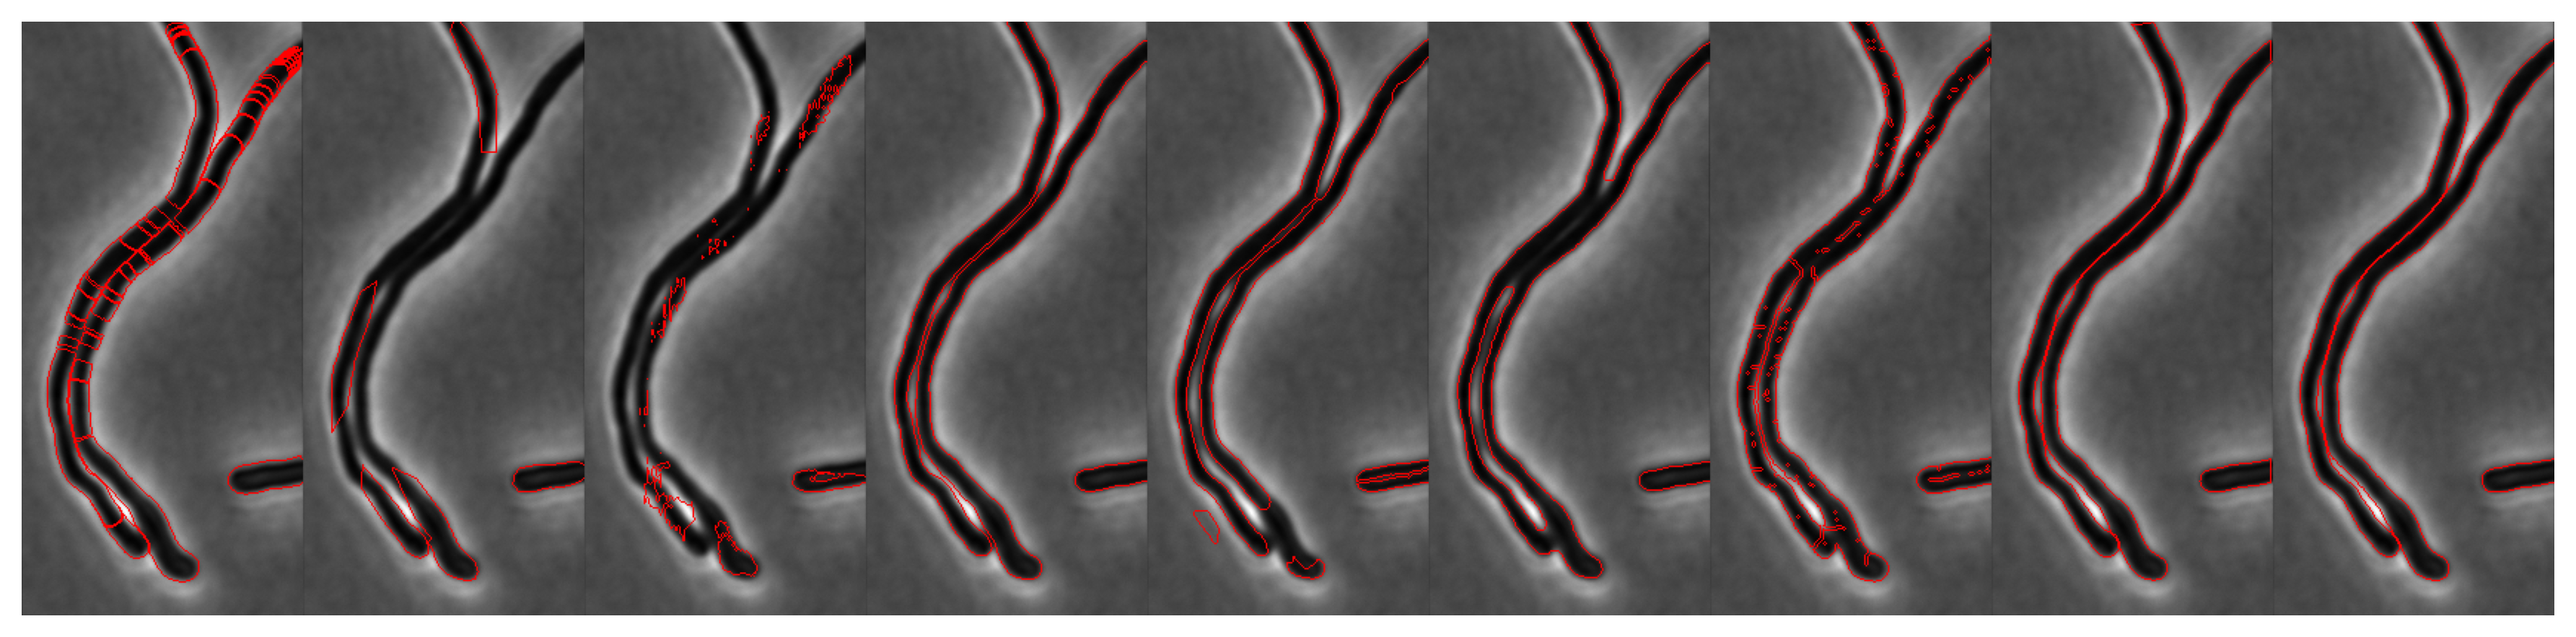

/home/kcutler/DataDrive/omnipose_test/streptomyces/streptomyces_XY17_1_masks.tif
shape (150, 173)


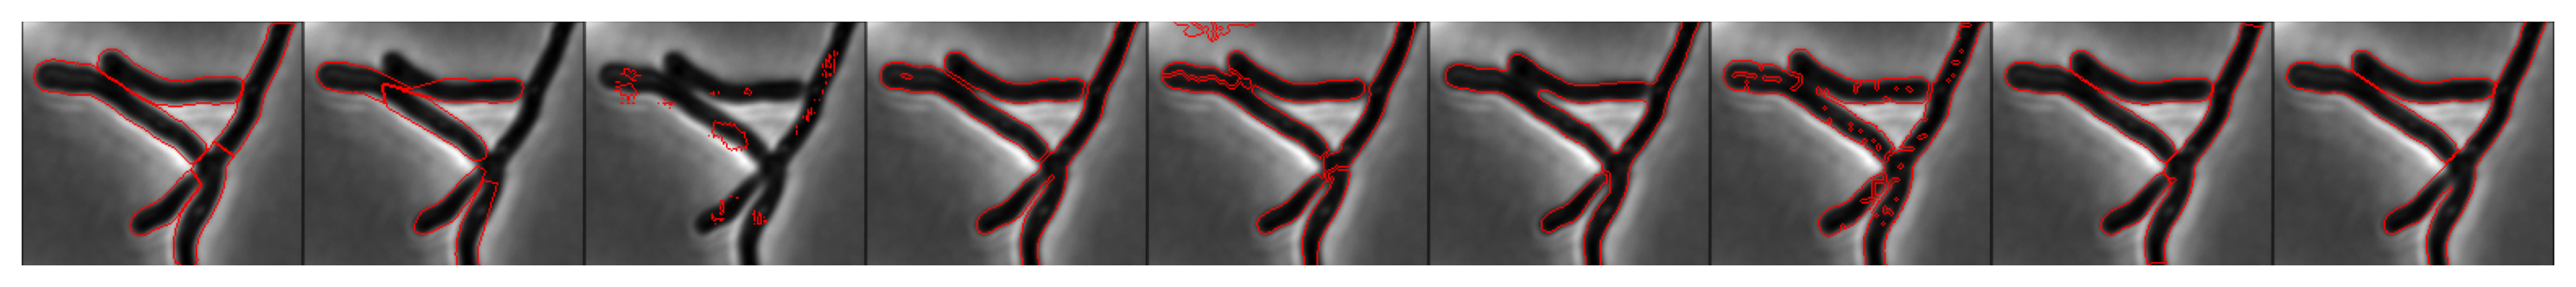

/home/kcutler/DataDrive/omnipose_test/streptomyces/streptomyces_XY2_3_masks.tif
shape (800, 624)


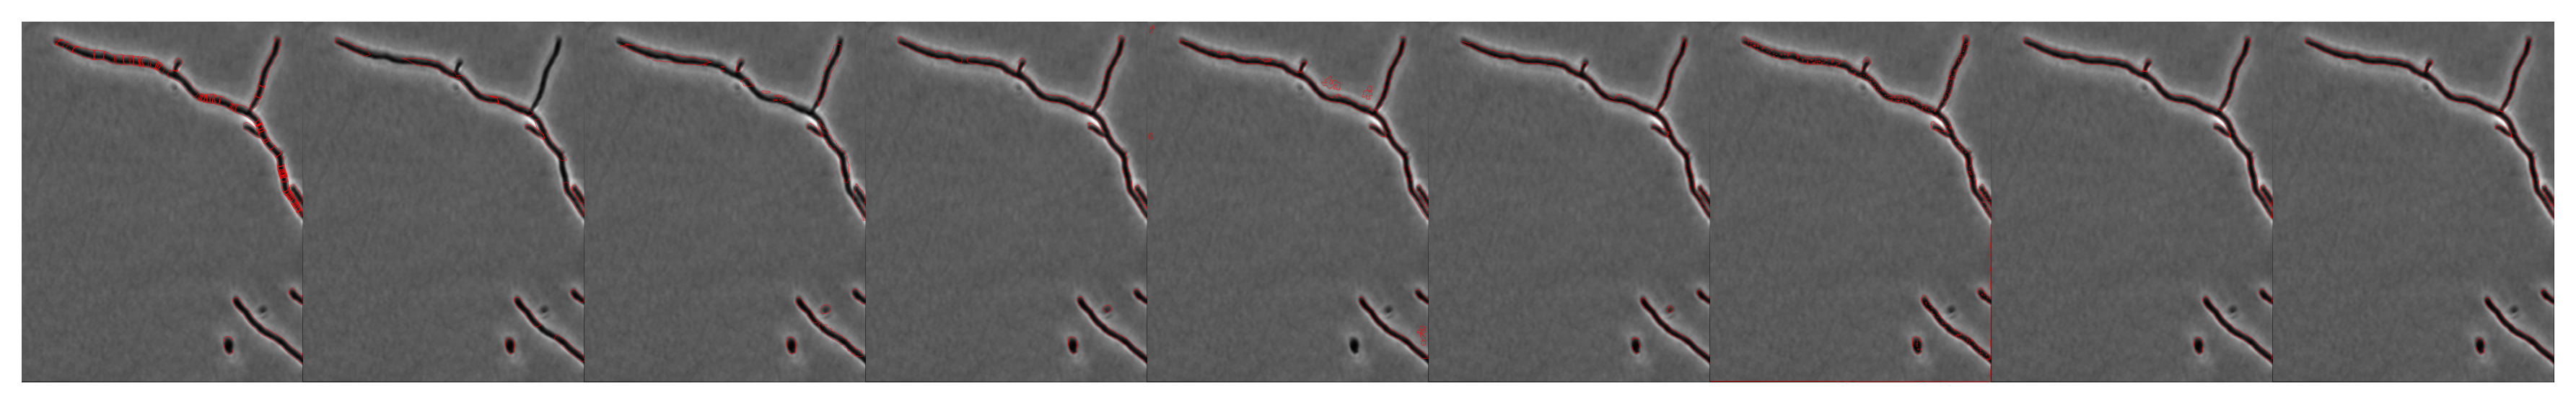

In [51]:
print(names)
# for ind in [indices[1][0]]:
for ind in indices[-1]:
# for ind in fig1_indices:
    print(mask_names[ind])
    im = imgs[ind]
    print('shape',im.shape)
    mask_gt = masks_gt[ind]
    masks_all = [m[ind] for m in masks]
    masks_all.append(mask_gt)
    
    outli = [plot.outline_view(omnipose.utils.rescale(im),m) for m in masks_all]
    
    fig = plt.figure(figsize=(12,5))
    plt.imshow(np.hstack(outli))
#     plt.imshow(im)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
#     plt.imshow(mask_gt)
#     plt.axis('off')
#     plt.tight_layout()
#     plt.show()

In [52]:
# crop_dict = {'Az_branch_ec_0_': (372, 163, 170, 160),
#              'Az_branch_ec_10_': (268, 236, 180, 120),
#              'Az_branch_ec_14_': (418, 297, 190, 120),
#              'PSVB_ensemble_c_0_': (330, 350, 160, 230),
#              'PSVB_ensemble_c_1_': (0, 0, 190, 390),
#              'streptomyces_XY15_1_': (0, 425, 330, 150)}
a = 160
crop_dict = {'Az_branch_ec_0_': (0, 425, 330, a),
             'Az_branch_ec_14_': (372, 163, 175, a),
             'Az_branch_ec_10_': (430, 297, a, 120),
             'PSVB_ensemble_c_0_': (268, 220, 180, a),
             'PSVB_ensemble_c_1_': (330, 350, a, 230),
             'streptomyces_XY15_1_': (0, 0, a, 390)}

dict_names = list(crop_dict.keys())

In [53]:
len(indices[-1])

6

In [60]:
def rgb_pad(im, pad, c=255):
    w = 3
    im = np.pad(im,((w,w),(w,w),(0,0)),constant_values=0)
    return np.pad(im,((pad,pad),(pad,pad),(0,0)),constant_values=c)

# cmap = matplotlib.cm.get_cmap('viridis')
from matplotlib.colors import ListedColormap
from skimage.segmentation import find_boundaries
colors = [color for color in sinebow(5).values()]
colors[0] = [1,1,1]
colormap = ListedColormap(colors)

# outline_col = np.array([212,175,55])/255
cmap = mpl.cm.get_cmap('plasma')
outline_col = cmap(0.85)[:3]


basedir = '/home/kcutler/DataDrive/omnipose_paper/Figure 1/grid'
io.check_dir(basedir)
    
%matplotlib inline
# produce vector inline graphics
# import matplotlib_inline
# matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('retina', 'png')

bg = 0.5
F = len(dict_names)
pad = 5
c = 255
rows = []
# for i in range(F):
selection = [1,4,5]
# fig, axs = plt.subplots(len(selection), len(names)+1, figsize=(10, 10))#,sharex=True,constrained_layout = True)
coords = np.zeros((len(selection), len(names)+1,2))
grid_ious = np.zeros((len(selection), len(names)+1))
for idx,i in enumerate(selection):
    ind = fig1_indices[i]
    name = fig1_names[i]
    bbx = crop_dict[name]
    print(bbx,name)
    img0 = omnipose.utils.normalize99(imgs[ind])
#     print(img0.shape)
    p = img0[bbx[1]:bbx[1]+bbx[3],bbx[0]:bbx[0]+bbx[2]]

    
    mgt = masks_gt[ind][bbx[1]:bbx[1]+bbx[3],bbx[0]:bbx[0]+bbx[2]]
    im = omnipose.utils.normalize_image(p,mgt,bg)
    mgt,remap = fastremap.renumber(mgt) 
    print(np.unique(mgt))
    masks_all = []
    for m in masks:
        m0 = m[ind][bbx[1]:bbx[1]+bbx[3],bbx[0]:bbx[0]+bbx[2]]
        m0, remap = fastremap.renumber(m0) 
        masks_all.append(m0)
    ious = [metrics._intersection_over_union(mgt, m)[1:, 1:] for m in masks_all]
    for j,iou in enumerate(ious):
        
        # this metric finds the maximum iou along the GT axis and averages the nonzero ones
        # this is biases and allows double-counting 
        max_iou = np.max(iou,axis=0)
        v = np.mean(max_iou[max_iou>0]) 
        
        # instead figure out the best assignment and average that 
        th = 0
        n_min = min(iou.shape[0], iou.shape[1])
        costs = -(iou >= th).astype(float) - iou / (2*n_min)
        true_ind, pred_ind = linear_sum_assignment(costs)
        
        v = np.sum(iou[true_ind, pred_ind])/max(iou.shape[0], iou.shape[1]) # instead of average over existing matches, this penalizes matches not found (effectively setting those ious to 0)

        print(v,iou.shape,len(true_ind),len(pred_ind))
        grid_ious[idx][j] = v
        
        # 
        # print('match',miou,pred_ind,mask_match,pred_inds,true_ind)
        with open(os.path.join(basedir,'MMiou_cell_'+str(i)+'_'+names[j] +'.txt'), "w") as text_file:
            print(f"Mean Matched IoU: {np.mean(v)}", file=text_file)
            
    outli_y = [plot.outline_view(im,m,outline_col,mode='thick') for m in masks_all]
    outli_r = [plot.outline_view(im,m) for m in masks_all]
    
    raw_outlines = [find_boundaries(m,mode='inner') for m in masks_all]
    color_outlines = [find_boundaries(m,mode='inner')*m for m in masks_all]
    
    height,width = mgt.shape
    flip = height<width and (i != 2)
    if flip:
        mgt = np.transpose(mgt)
        im =  np.transpose(im)
    
    for k in range(len(outli)):
        if flip:
            outli_y[k] = np.transpose(outli_y[k],(1,0,2))
            outli_r[k] = np.transpose(outli_r[k],(1,0,2))
            raw_outlines[k] = np.transpose(raw_outlines[k])
            color_outlines[k] = np.transpose(color_outlines[k])
            masks_all[k] = np.transpose(masks_all[k])
        

        coords[idx][k][1] = (k+1)*(2*pad+width) - pad
        if idx>0:
            coords[idx][k][0] = coords[idx-1][k][0] + 2*pad + height
        else:
            coords[idx][k][0] = pad + height
    
    K = len(masks_all)
    img0 = np.stack([omnipose.utils.rescale(im)]*3,axis=-1)
    ncolor = omnipose.utils.ncolorlabel(mgt)
    grey_n = np.stack([1-omnipose.utils.rescale(ncolor)]*3,axis=-1)
    color_n = colormap(ncolor)[:,:,:3]
#     gt_array = np.hstack((rgb_pad(img0, pad),rgb_pad(colormap(omnipose.utils.ncolorlabel(mgt))[:,:,:3],pad)))
    gt_array = np.hstack((rgb_pad(img0, pad),rgb_pad(grey_n,pad)))
    gt_array = np.pad(gt_array,((0,0),(0,5*pad),(0,0)),constant_values=c) # five spacing between 
                         
    seg_array = np.hstack([rgb_pad(outli_r[k],pad) for k in range(K)])

    row = np.hstack([gt_array,seg_array])
    if idx<len(selection)-1:
        row = np.pad(row,((0,5*pad),(0,0),(0,0)),constant_values=c)
#     plt.imshow()
#     plt.axis('off')
#     plt.show()
    rows.append(row)
    
    #saving:
   
    ext = '.png'
    basename = 'cell_'+str(i)
    savepath = os.path.join(basedir,basename + 'raw_phase'+ext)
    io.imsave(savepath,np.uint8(img0*255))
    savepath = os.path.join(basedir,basename + 'masks_color'+ext)
    io.imsave(savepath,np.uint8(color_n*255))
    savepath = os.path.join(basedir,basename + 'masks_gray'+ext)
    io.imsave(savepath,np.uint8(grey_n*255))
    for k in range(len(masks_all)): 
        filename =  basename+'_'+names[k] + '_yellow' + ext
        savepath = os.path.join(basedir, filename)
        io.imsave(savepath,np.uint8(outli_y[k]*255))
        
        filename =  basename+'_'+names[k] + '_red'+ ext
        savepath = os.path.join(basedir, filename)
        io.imsave(savepath,np.uint8(outli_r[k]*255))
        
        filename =  basename+'_color_pred_'+names[k]  + '.eps'
        savepath = os.path.join(basedir, filename)
        skimage.io.imsave(savepath,np.uint8(colormap(omnipose.utils.ncolorlabel(masks_all[k]))[:,:,:3]*255))
        
        

# outlines = np.array(outlines,dtype=object)
grid = np.vstack(rows)
grid = np.pad(grid,((pad,pad),(pad,pad),(0,0)),constant_values=c)

(372, 163, 175, 160) Az_branch_ec_14_
[0 1 2]
0.9297893756909292 (2, 2) 2 2
0.3614986050219211 (2, 1) 1 1
0.10234419507132421 (2, 3) 2 2
0.25147171743025337 (2, 1) 1 1
0.1851208884038612 (2, 4) 2 2
0.3284992878415124 (2, 1) 1 1
0.028811242109594737 (2, 18) 2 2
0.9400191484456628 (2, 2) 2 2
(330, 350, 160, 230) PSVB_ensemble_c_1_
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28]
0.8898062843483193 (28, 28) 28 28
0.8262541798065237 (28, 26) 26 26
0.4821354366811686 (28, 16) 16 16
0.6664286755785217 (28, 24) 24 24
0.2215592427997757 (28, 14) 14 14
0.5073972814873396 (28, 29) 28 28
0.06844667861056541 (28, 138) 28 28
0.9698816448720848 (28, 28) 28 28
(0, 0, 160, 390) streptomyces_XY15_1_
[0 1 2 3]
0.03938994937976704 (3, 36) 3 3
0.27358958268587963 (3, 5) 3 3
0.13922248673320553 (3, 7) 3 3
0.9078309159445915 (3, 3) 3 3
0.31176039789575466 (3, 6) 3 3
0.4107730822826024 (3, 2) 2 2
0.6270267333087398 (3, 3) 3 3
0.9592287876961172 (3, 3) 3 3


2021-10-20 17:15:19,281 [WARNING] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


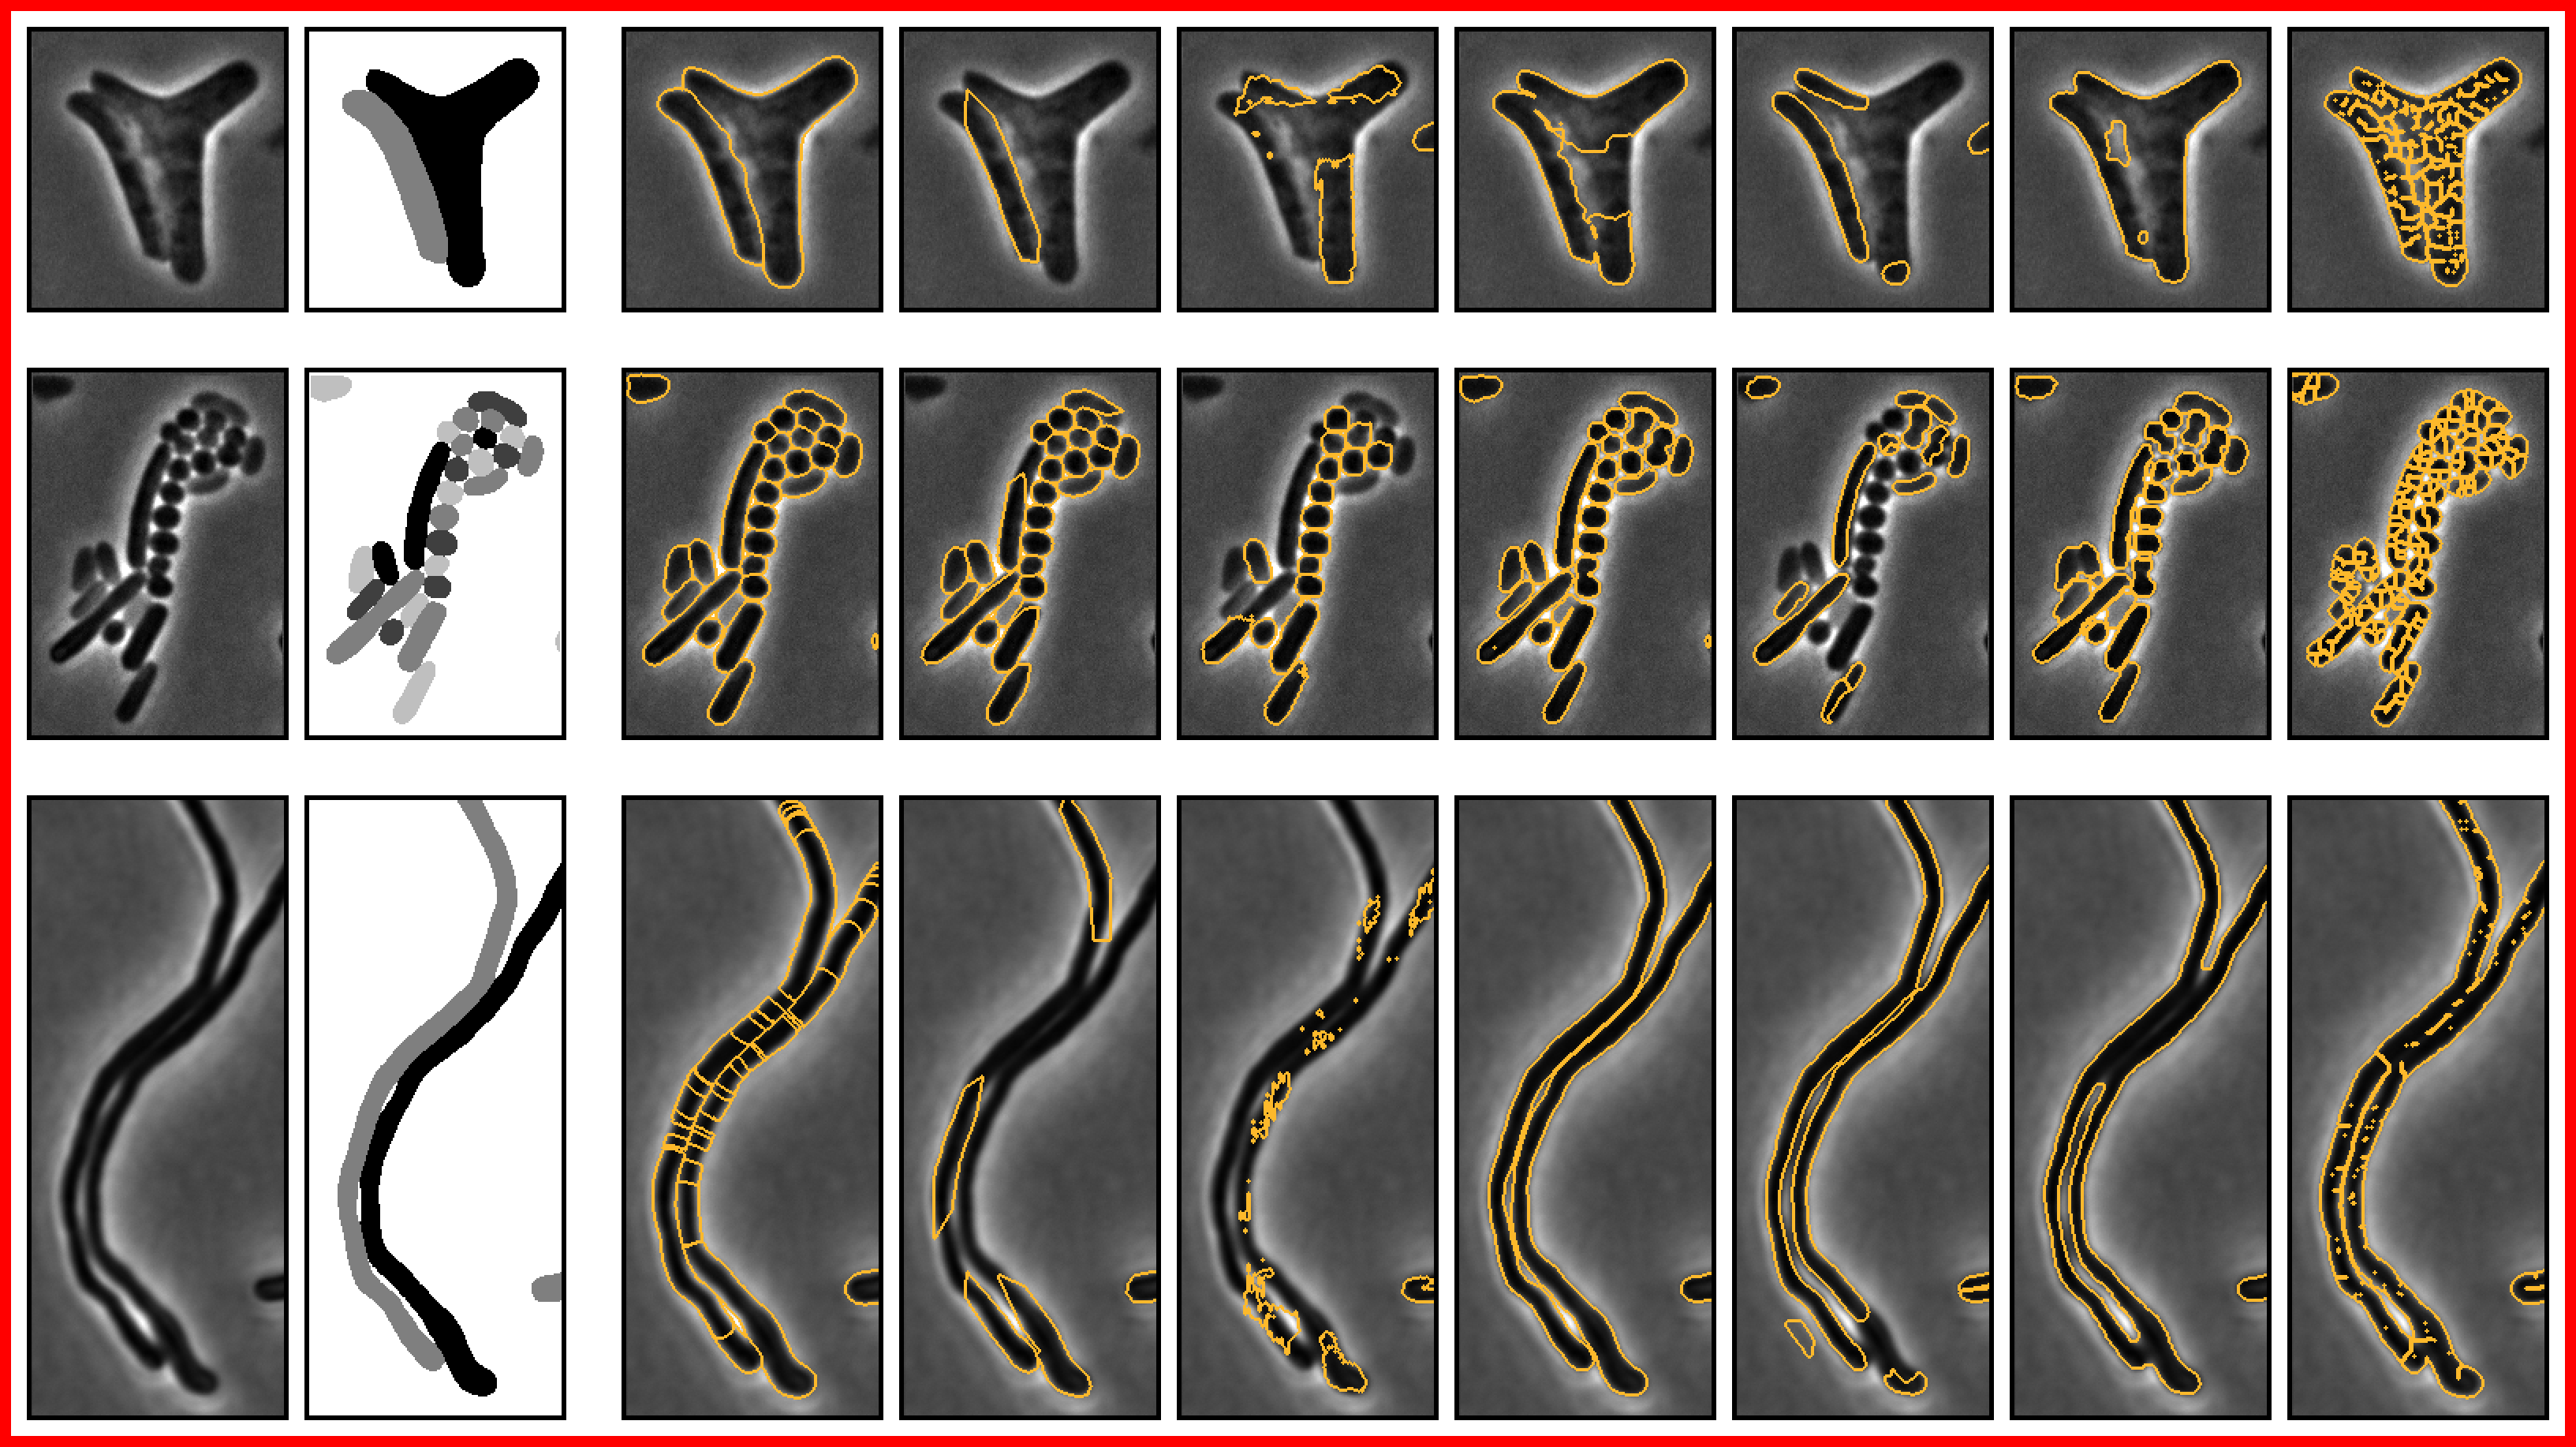

In [119]:
scale=1
fig = plt.figure(figsize=(scale*grid.shape[1]/72,scale*grid.shape[0]/72))
# plt.imshow(cv2.resize((grid).astype(np.uint8)dsize=(scale*grid.shape[1],scale*grid.shape[0]), interpolation=cv2.INTER_NEAREST),interpolation='nearest')
# plt.matshow(grid)
plt.imshow(grid,interpolation='none')
offset = [-1,-1]
# for r in range(len(rows))
# for i in range(coords.shape[0]):
#     for j in range(coords.shape[1]):
for i in [0]:
    for j in [0]:
        y,x = coords[i][j]+[0,30]
        x += 2*width+7*pad
#         print(x,y)
        # plt.text(x, y, ('%.3f' % grid_ious[i][j]),color='w',ha = 'right',va='bottom',fontsize=12) #set rcparams to use font family


# fig.axes.get_xaxis().set_visible(False)
# fig.axes.get_yaxis().set_visible(False)
plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
            hspace = 0, wspace = 0)
plt.axis('off')
fig.patch.set_facecolor('r')
plt.show()

#MAYBE use different 4-color scheme/tint for masks based on group 
# plt.savefig(os.path.join(basedir,'grid.pdf'))

In [ ]:
base = '/home/kcutler/DataDrive/omnipose_paper/qualitative_grid_mean_match_iou'
fig.savefig(base+'.eps',bbox_inches="tight",pad_inches = 0.0)
fig.savefig(base+'.png',bbox_inches="tight",pad_inches = 0.0)
fig.savefig(base+'.pdf',bbox_inches="tight",pad_inches = 0.0)

In [ ]:
ws = np.unique([lines.shape[1] for outli in outlines for lines in outli])
hs = np.unique([lines.shape[0] for outli in outlines for lines in outli])
print(ws,hs)
np.lcm.reduce(hs)

In [96]:
basedir

'/home/kcutler/DataDrive/skelpose_paper/newfig2'

In [ ]:
imgs = [io.imread(f) for f in img_names]

In [ ]:
masks_gt_raw = [skimage.io.imread(f) for f in mask_names]


In [ ]:
indices[1][0]

In [ ]:
from interactivecrop.interactivecrop import main as crop
crop([omnipose.utils.rescale(imgs[i])*255 for i in fig1_indices],image_name_list = fig1_names)

In [ ]:
np.transpose(outli[0],(1,0,2)).shape

In [ ]:
outli[0].shape

In [ ]:


# modeldir_orig = '/home/kcutler/DataDrive/omnipose_train/registered/models/cellpose_residual_on_style_on_concatenation_off_registered_2021_07_22_11_48_00.465748' #500 epochs, bs 8, lr .2
# model = models.CellposeModel(gpu=use_GPU, pretrained_model=modeldir_orig)
# masks, flows, styles = model.eval(imgs,channels=[0,0],rescale=None,dist_threshold=-1,flow_threshold=0)

# basedir = '/home/kcutler/DataDrive/omnipose_paper/Cellpose_StarDist_Etc_Comparison'
# if not os.path.isdir(basedir):
#     os.mkdir(basedir)
# savedir = os.path.join(basedir,'original_cellpose')

# if not os.path.isdir(savedir):
#     os.mkdir(savedir)
# io.save_masks(imgs, masks, flows, img_names,save_flows=True,save_outlines=True,savedir=savedir,png=False,tif=True)
# cellpose_dir

# stardist_dir = '/home/kcutler/DataDrive/omnipose_paper/Comparison Examples StarDist Bacteria'